In [72]:
# Setup: imports, global config, and paths
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pca import pca

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (7, 5)

# Resolve raw and clean paths robustly relative to working directory
RAW_CANDIDATES = [
    os.path.join('../data', 'koi.csv'),
    os.path.join('../..', 'data', 'koi.csv'),
]
RAW_PATH = next((p for p in RAW_CANDIDATES if os.path.isfile(p)), RAW_CANDIDATES[0])
DATA_DIR = os.path.dirname(RAW_PATH) if os.path.basename(RAW_PATH) else os.path.join('../data')
CLEAN_PATH = os.path.join(DATA_DIR, 'koi_clean.csv')

In [73]:
# Column groups (kept consistent with the framework)
IDENTIFIER_COLS = [
    'kepid',            # Kepler Catalog ID
    'kepoi_name',       # KOI Name
    'kepler_name',      # Official Kepler Planet Name (if any)
]

TARGET_COL = 'koi_score'

LABEL_COLS = [
    'koi_disposition',     # Exoplanet Archive Disposition
    'koi_pdisposition',    # Disposition Using Kepler Data
    'koi_fpflag_nt',       # Not Transit-Like FP flag
    'koi_fpflag_ss',       # Stellar Eclipse FP flag
    'koi_fpflag_co',       # Centroid Offset FP flag
    'koi_fpflag_ec',       # Ephemeris Match FP flag
]

FEATURE_COLS = [
    # 1) Transit geometry & signal quality
    'koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_model_snr',
    # 2) Planet properties & irradiation
    'koi_prad', 'koi_teq', 'koi_insol',
    # 3) Stellar properties
    'koi_steff', 'koi_slogg', 'koi_srad',
    # 4) Brightness (observation quality)
    'koi_kepmag',
]

# Always drop from feature matrix (metadata), per framework
DROP_ALWAYS = ['koi_tce_plnt_num', 'koi_tce_delivname']

ALL_KEEP_COLS = IDENTIFIER_COLS + [TARGET_COL] + LABEL_COLS + FEATURE_COLS

In [74]:
# Data cleaning function and build clean CSV
def clean_koi(raw_path: str, out_path: str) -> pd.DataFrame:
    """
    Load raw KOI CSV, select relevant columns, enforce basic validity of koi_score,
    and save a clean CSV for downstream use.
    """
    # Load raw CSV; ignore NASA header comments starting with '#'
    df = pd.read_csv(raw_path, comment='#', low_memory=False)
    orig_rows = len(df)
    df.columns = df.columns.str.strip()

    # Keep only the specified columns if present
    keep_cols = [c for c in ALL_KEEP_COLS if c in df.columns]
    df = df.loc[:, keep_cols].copy()

    # Drop exact duplicate rows
    before_dupes = len(df)
    df = df.drop_duplicates()
    dropped_dupes = before_dupes - len(df)

    # Coerce numeric columns
    numeric_cols = set(FEATURE_COLS + [TARGET_COL, 'kepid'])
    numeric_cols.update([c for c in LABEL_COLS if c.startswith('koi_fpflag_')])
    numeric_cols = [c for c in numeric_cols if c in df.columns]
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Remove rows with missing target
    before_drop_y_na = len(df)
    df = df.dropna(subset=[TARGET_COL])
    dropped_y_na = before_drop_y_na - len(df)

    # Enforce koi_score within [0, 1]
    before_range = len(df)
    mask_valid = (df[TARGET_COL] >= 0.0) & (df[TARGET_COL] <= 1.0)
    df = df.loc[mask_valid].copy()
    dropped_out_of_range = before_range - len(df)

    # Drop rows missing any of the 12 features used downstream
    present_feats = [c for c in FEATURE_COLS if c in df.columns]
    before_drop_feat_na = len(df)
    df = df.dropna(subset=present_feats)
    dropped_feat_na = before_drop_feat_na - len(df)

    # Normalize string columns
    for c in ['kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition']:
        if c in df.columns:
            df[c] = df[c].astype('string').str.strip()

    # Save clean CSV
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df.to_csv(out_path, index=False)

    print(f'Loaded rows: {orig_rows}')
    print(f'Dropped exact duplicates: {dropped_dupes}')
    print(f'Dropped missing koi_score: {dropped_y_na}')
    print(f'Dropped out-of-range koi_score: {dropped_out_of_range}')
    print(f'Dropped rows missing any of the 12 features: {dropped_feat_na}')
    print(f'Kept columns ({len(keep_cols)}): {keep_cols}')
    print(f'Final shape: {df.shape}')
    print(f'Saved to: {out_path}')
    return df

# Run cleaning once to produce data/koi_clean.csv
FORCE_REBUILD = False  # set True to overwrite existing clean file if needed
if FORCE_REBUILD or (not os.path.exists(CLEAN_PATH)):
    _df_clean = clean_koi(RAW_PATH, CLEAN_PATH)
else:
    print(f'Clean file already exists at {CLEAN_PATH}. Set FORCE_REBUILD=True and re-run this cell to rebuild.')


Clean file already exists at ../data\koi_clean.csv. Set FORCE_REBUILD=True and re-run this cell to rebuild.


Loaded clean dataset: 7994 rows x 22 columns

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7994 entries, 0 to 7993
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepid             7994 non-null   int64  
 1   kepoi_name        7994 non-null   object 
 2   kepler_name       2729 non-null   object 
 3   koi_score         7994 non-null   float64
 4   koi_disposition   7994 non-null   object 
 5   koi_pdisposition  7994 non-null   object 
 6   koi_fpflag_nt     7994 non-null   int64  
 7   koi_fpflag_ss     7994 non-null   int64  
 8   koi_fpflag_co     7994 non-null   int64  
 9   koi_fpflag_ec     7994 non-null   int64  
 10  koi_period        7994 non-null   float64
 11  koi_impact        7994 non-null   float64
 12  koi_duration      7994 non-null   float64
 13  koi_depth         7994 non-null   float64
 14  koi_model_snr     7994 non-null   float64
 15  koi_prad          7994 non-

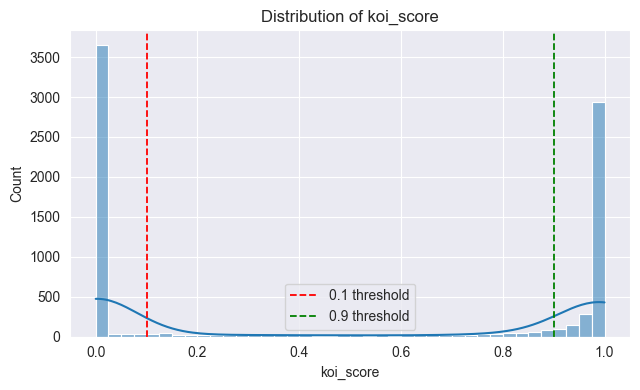


After applying koi_score thresholds:
  Labeled samples: 7211
  Label distribution (0=low quality, 1=high quality):
quality_label
0    3753
1    3458
Name: count, dtype: int64


In [75]:
# Load the cleaned dataset and perform basic EDA + binary label construction
CLEAN_CANDIDATES = [
    os.path.join('../data', 'koi_clean.csv'),
    os.path.join('../..', 'data', 'koi_clean.csv'),
]
CLEAN_PATH = next((p for p in CLEAN_CANDIDATES if os.path.isfile(p)), CLEAN_CANDIDATES[0])
df = pd.read_csv(CLEAN_PATH, low_memory=False)

print(f'Loaded clean dataset: {df.shape[0]} rows x {df.shape[1]} columns')

# Basic inspection
print('\nDataFrame info:')
df.info()
print('\nSummary statistics for koi_score and selected features:')
print(df[['koi_score'] + FEATURE_COLS].describe())
print(f"Number of exact duplicate rows: {df.duplicated().sum()}")

# koi_score distribution with thresholds 0.1 and 0.9
plt.figure(figsize=(6.5, 4.0))
sns.histplot(df['koi_score'].dropna(), bins=40, kde=True, color='#1f77b4')
plt.axvline(0.1, color='red', linestyle='--', linewidth=1.3, label='0.1 threshold')
plt.axvline(0.9, color='green', linestyle='--', linewidth=1.3, label='0.9 threshold')
plt.title('Distribution of koi_score')
plt.xlabel('koi_score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Binary quality label construction based on koi_score (per FRAMEWORK)
df['quality_label'] = np.nan
df.loc[df['koi_score'] >= 0.9, 'quality_label'] = 1
df.loc[df['koi_score'] <= 0.1, 'quality_label'] = 0
df_labeled = df.dropna(subset=['quality_label']).copy()
df_labeled['quality_label'] = df_labeled['quality_label'].astype(int)

print('\nAfter applying koi_score thresholds:')
print(f'  Labeled samples: {df_labeled.shape[0]}')
print('  Label distribution (0=low quality, 1=high quality):')
print(df_labeled['quality_label'].value_counts().sort_index())

# Pre-PCA transform specification (fixed per FRAMEWORK)
LOG10_COLS = ['koi_period','koi_duration','koi_prad','koi_teq','koi_insol','koi_srad']
LOG1P_COLS = ['koi_depth','koi_model_snr']
LINEAR_COLS = ['koi_impact','koi_steff','koi_slogg','koi_kepmag']


Using fixed transforms per FRAMEWORK:
  Log10 columns: ['koi_period', 'koi_duration', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_srad']
  Log10(1+x) columns: ['koi_depth', 'koi_model_snr']
  Linear columns: ['koi_impact', 'koi_steff', 'koi_slogg', 'koi_kepmag']


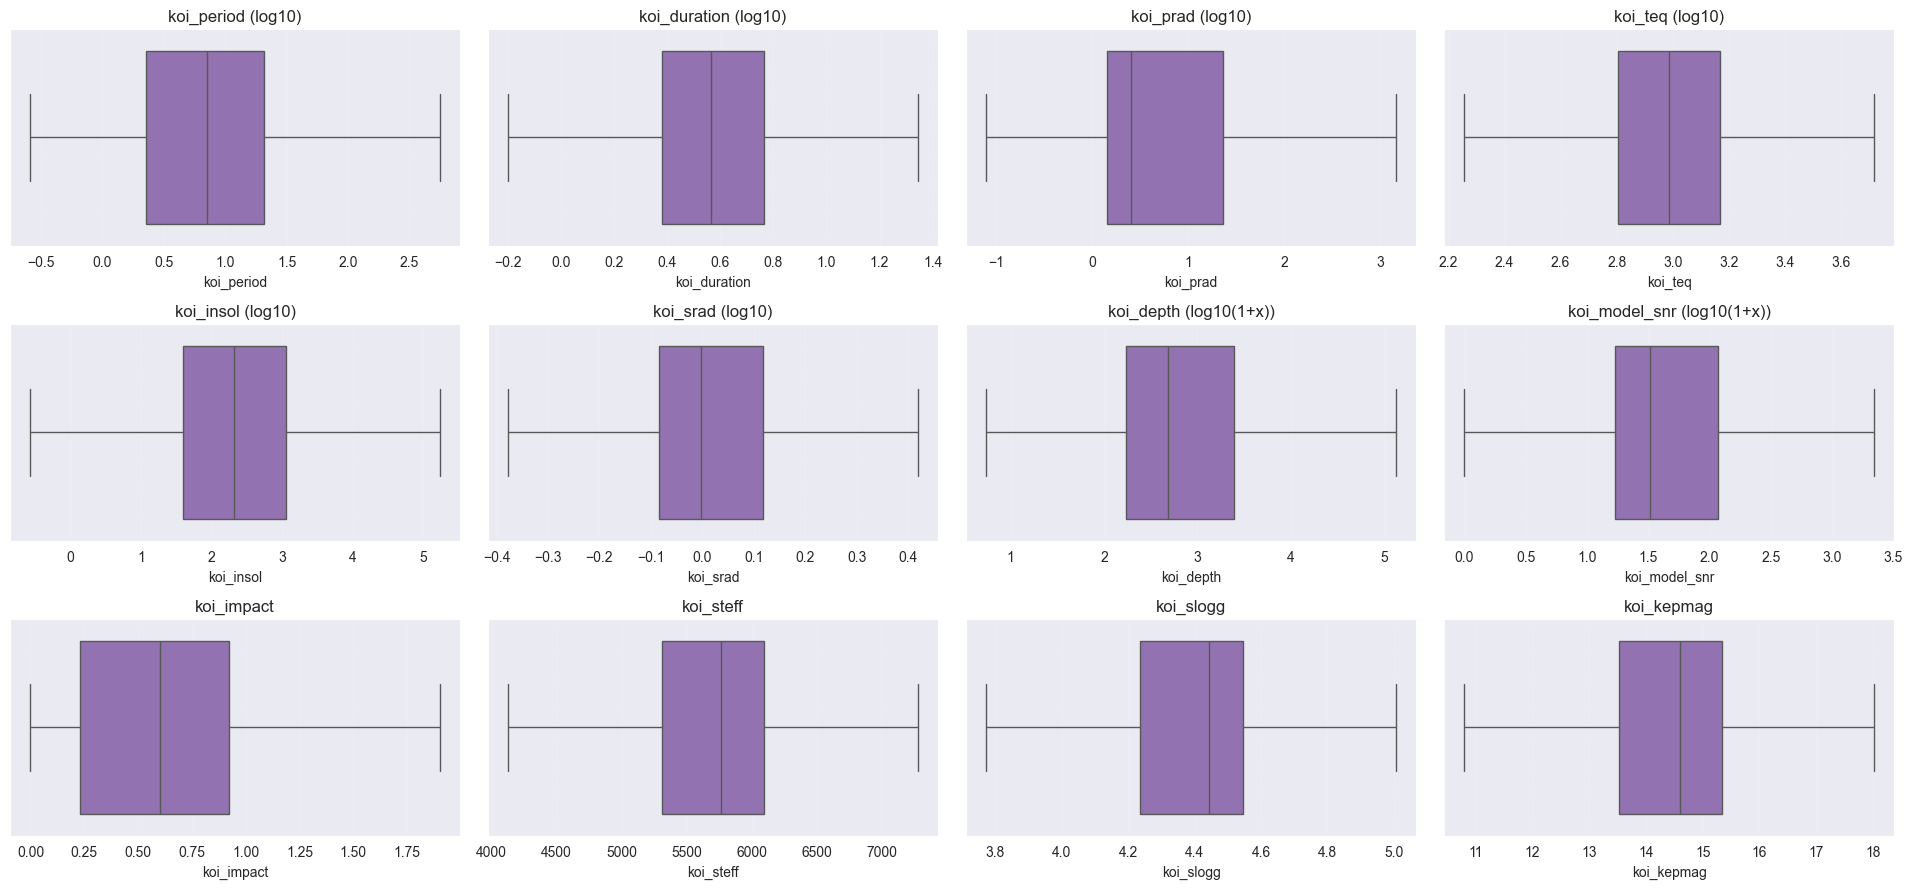

In [76]:
# EDA boxplots of transformed numerical features (using labeled subset)
# Use labeled subset and fixed transform lists per FRAMEWORK
feat_cols = LOG10_COLS + LOG1P_COLS + LINEAR_COLS
plot_df = df_labeled.loc[:, feat_cols].copy()

# Apply the same transforms that will be used for PCA
for col in LOG10_COLS:
    plot_df[col] = np.log10(np.clip(plot_df[col], 1e-12, None))
for col in LOG1P_COLS:
    plot_df[col] = np.log10(np.clip(plot_df[col] + 1.0, 1e-12, None))

print('Using fixed transforms per FRAMEWORK:')
print('  Log10 columns:', LOG10_COLS)
print('  Log10(1+x) columns:', LOG1P_COLS)
print('  Linear columns:', LINEAR_COLS)

cols_to_plot = feat_cols
ncols = 4
nrows = math.ceil(len(cols_to_plot) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4.8 * ncols, 3.0 * nrows), squeeze=False)

for i, col in enumerate(cols_to_plot):
    r, c = divmod(i, ncols)
    ax = axes[r][c]
    sns.boxplot(x=plot_df[col].dropna(), ax=ax, color='#9467bd', orient='h', whis=1.5, showfliers=False)
    tr = ' (log10)' if col in LOG10_COLS else (' (log10(1+x))' if col in LOG1P_COLS else '')
    ax.set_title(col + tr)
    ax.grid(True, axis='x', linestyle=':', alpha=0.35)

# Hide unused axes
total_axes = nrows * ncols
for j in range(len(cols_to_plot), total_axes):
    r, c = divmod(j, ncols)
    axes[r][c].set_visible(False)

plt.tight_layout()
plt.show()

In [77]:
# Build the 12-feature matrix (order as in FEATURE_COLS) with fixed pre-PCA transforms on labeled data
X_cols = [c for c in FEATURE_COLS if c in df_labeled.columns]
X_12 = df_labeled.loc[:, X_cols].copy()

# Apply transforms in-place, keeping original column order
for c in LOG10_COLS:
    if c in X_12.columns:
        X_12[c] = np.log10(np.clip(X_12[c], 1e-12, None))
for c in LOG1P_COLS:
    if c in X_12.columns:
        X_12[c] = np.log10(np.clip(X_12[c] + 1.0, 1e-12, None))

print(f'X_12 shape (labeled, transformed): {X_12.shape}')
X_12.head(10)

X_12 shape (labeled, transformed): (7211, 12)


,koi_period,koi_impact,koi_duration,koi_depth,koi_model_snr,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,0.977176,0.146,0.470925,2.790144,1.565848,0.354108,2.899273,1.971229,5455.0,4.467,-0.032920,15.347
1,1.735746,0.586,0.653888,2.942405,1.428135,0.451786,2.646404,0.959518,5455.0,4.467,-0.032920,15.347
2,1.298834,0.969,0.250956,4.034628,1.888179,1.164353,2.804821,1.594393,5853.0,4.544,-0.061480,15.436
3,0.239788,1.276,0.381370,3.907422,2.704665,1.524526,3.144574,2.950345,5805.0,4.564,-0.101824,15.597
4,0.402363,0.701,0.218667,2.781253,1.622214,0.439333,3.147985,2.966686,6031.0,4.438,0.019532,15.509
5,1.045101,0.538,0.662238,3.181415,1.829304,0.591065,2.921686,2.059980,6046.0,4.486,-0.012334,15.714
6,0.616416,0.762,0.496957,2.836957,1.614897,0.442480,3.064458,2.631088,6046.0,4.486,-0.012334,15.714
7,0.409356,0.755,0.385428,2.356981,1.204120,0.201397,3.133539,2.907272,6046.0,4.486,-0.012334,15.714
8,0.866983,1.169,0.700877,2.370513,1.687529,1.593397,3.127753,2.884920,6227.0,3.986,0.291813,12.660
9,1.205979,0.052,0.548353,3.691550,2.211921,0.760422,2.778151,1.487845,5031.0,4.485,-0.071604,15.841


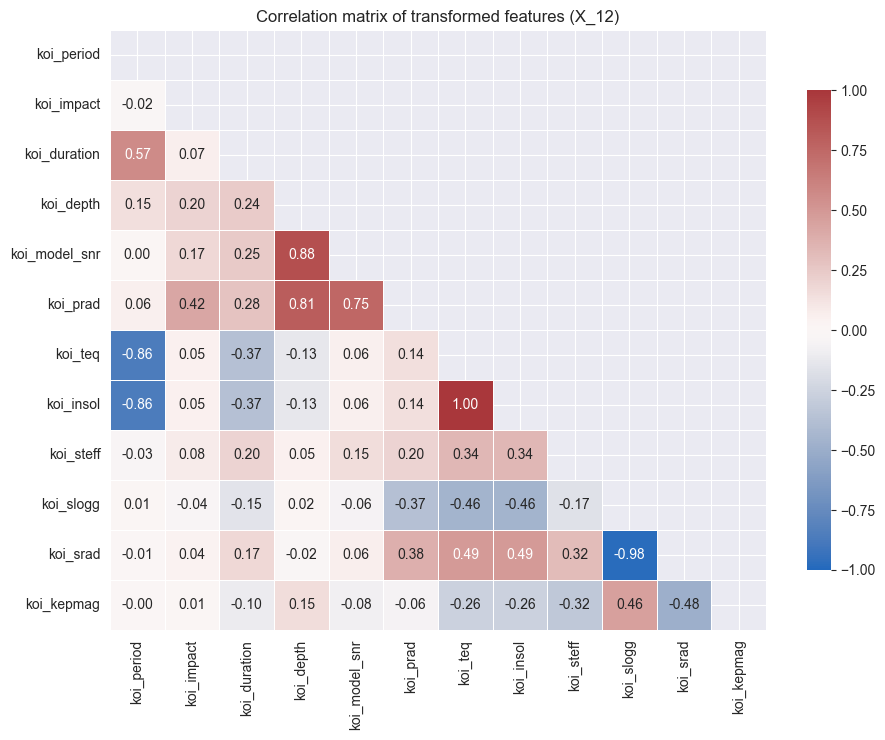

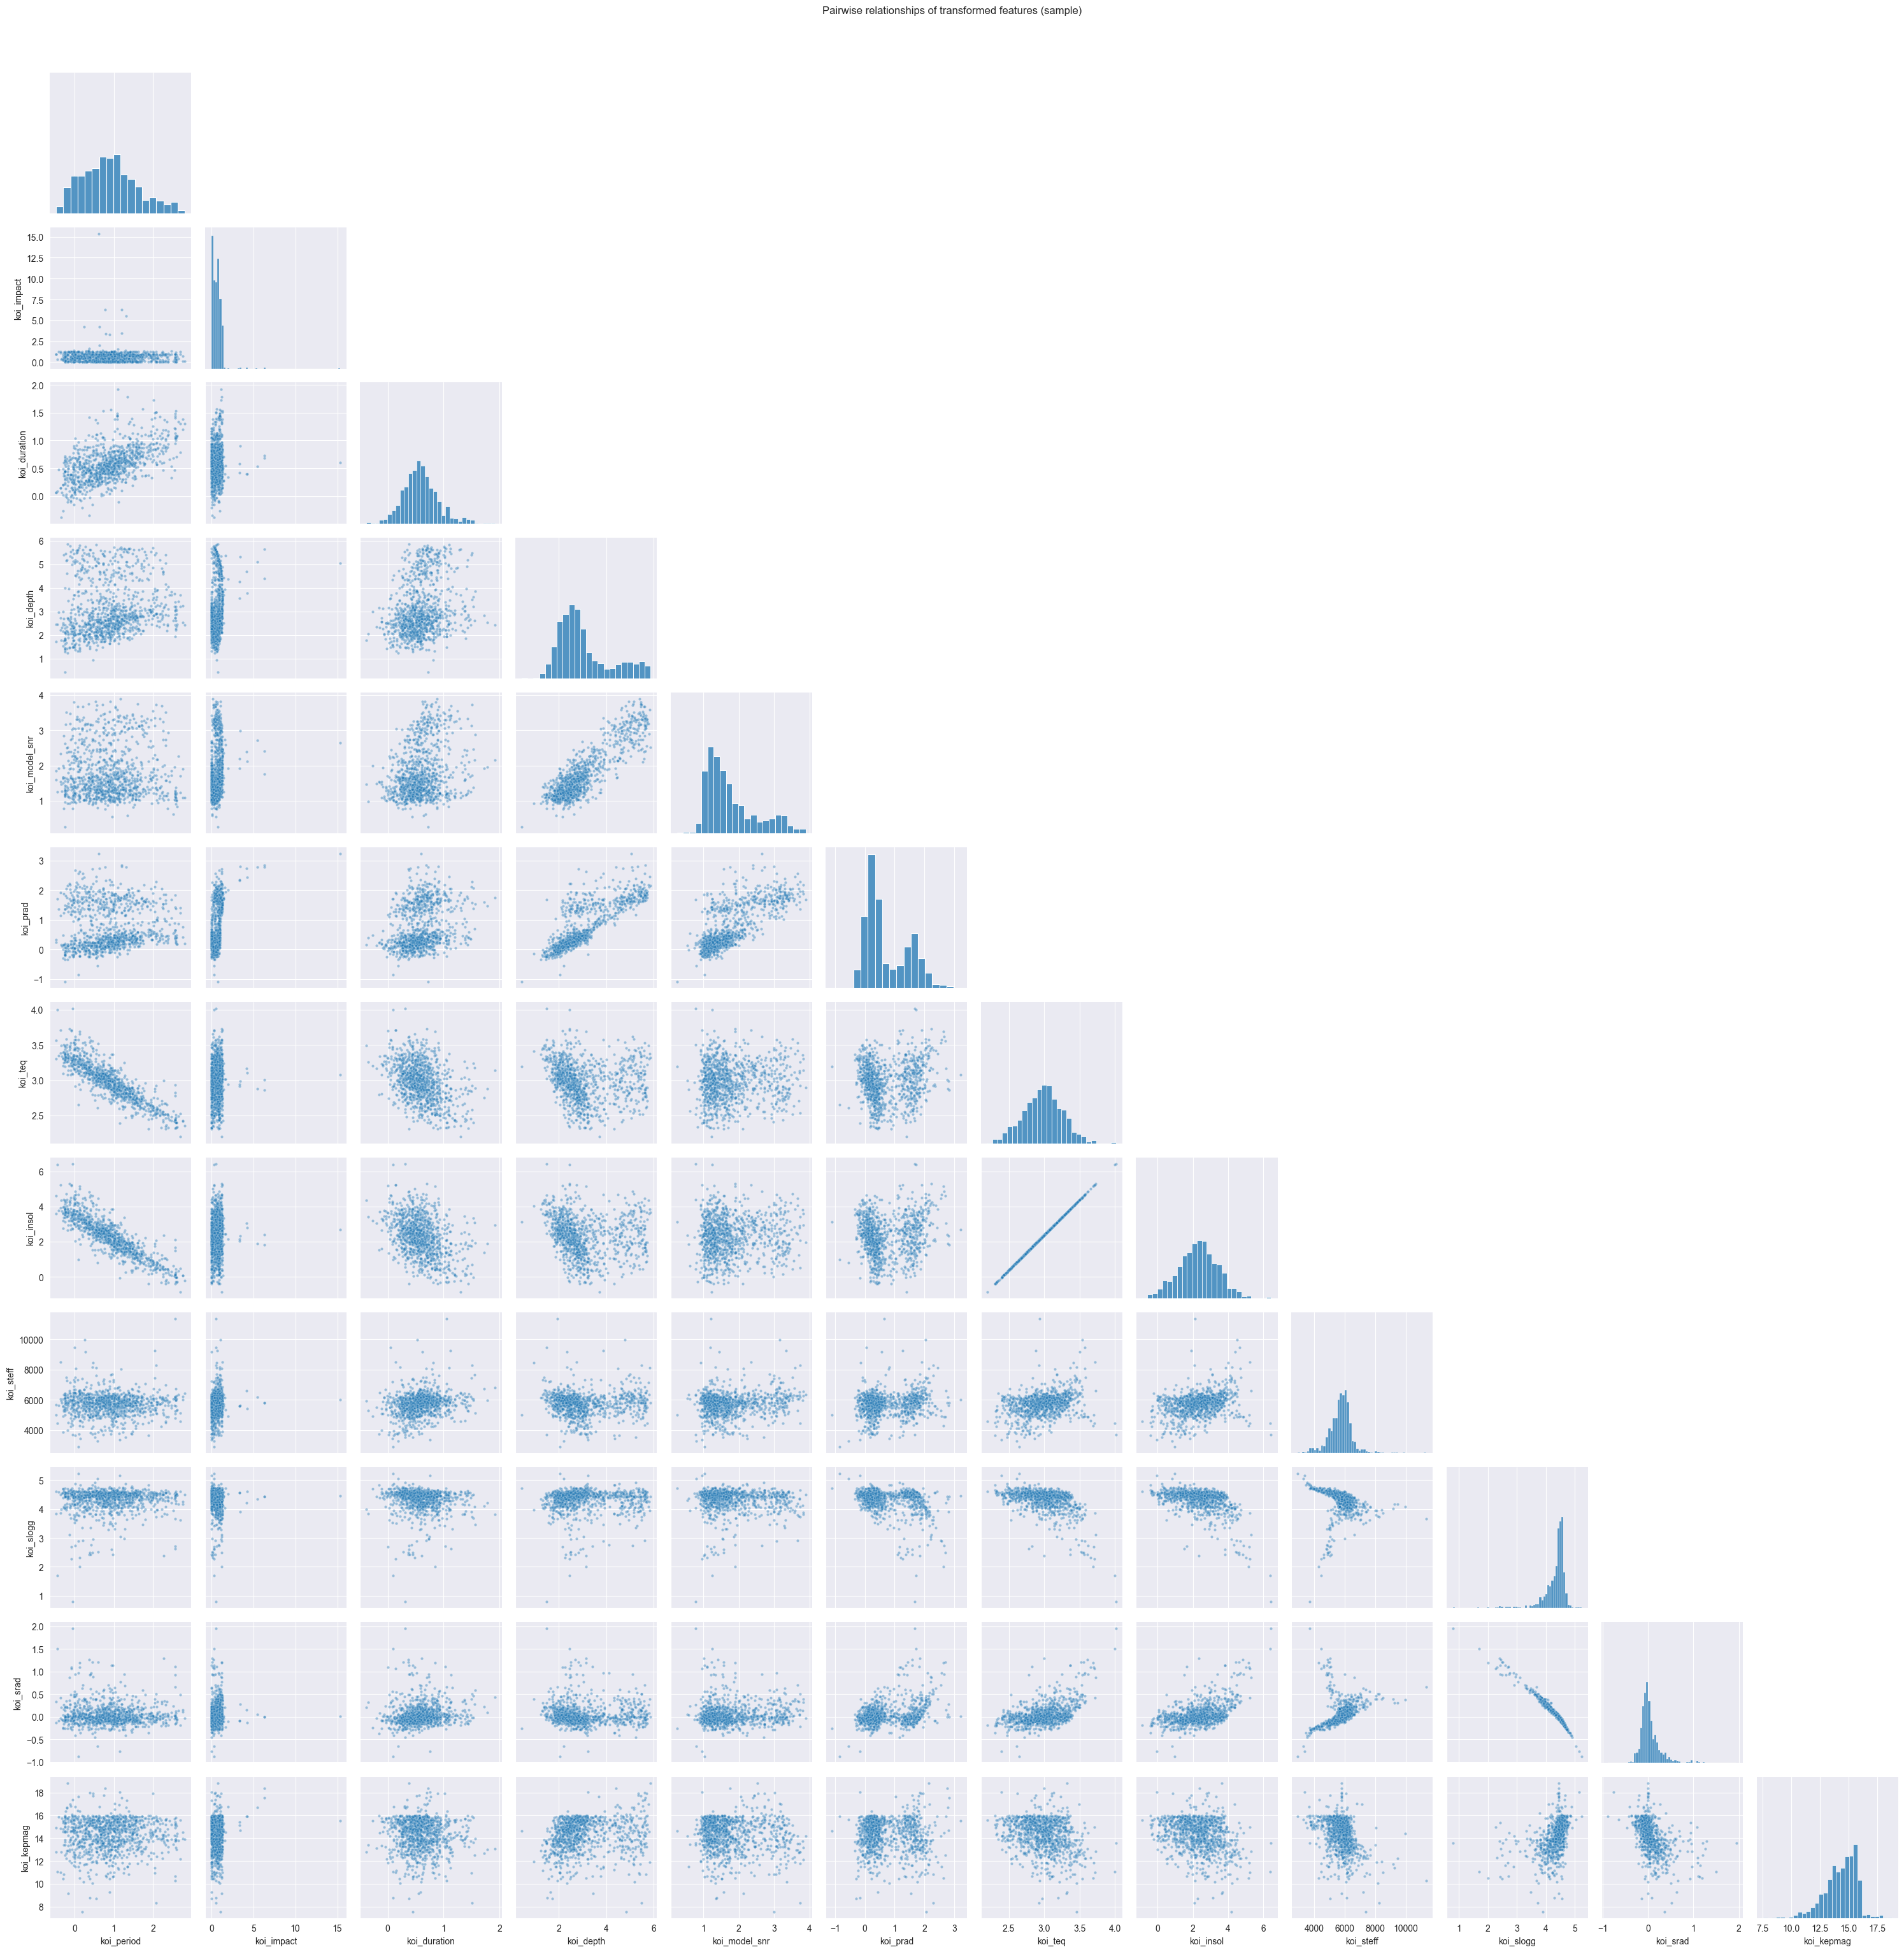

In [83]:
# Correlation heatmap of X_12
# Guard: require X_12 exists
if 'X_12' not in globals():
    raise RuntimeError('X_12 not found. Run the Pre-PCA 12-feature table cell first.')

corr = X_12.corr(numeric_only=True)

# 1) Correlation heatmap (lower triangle)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(9.5, 7.5))
sns.heatmap(corr, mask=mask, cmap='vlag', vmin=-1, vmax=1, center=0,
            annot=True, fmt='.2f', linewidths=0.5, cbar_kws=dict(shrink=0.8))
plt.title('Correlation matrix of transformed features (X_12)')
plt.tight_layout()
plt.show()

# 2) Pairplot to visualize bivariate relations between attributes (sampled for efficiency)
sample_size = min(1000, len(X_12))
X_pair = X_12.sample(n=sample_size, random_state=6220)
sns.pairplot(X_pair, corner=True, diag_kind='hist', plot_kws={'s': 10, 'alpha': 0.4})
plt.suptitle('Pairwise relationships of transformed features (sample)', y=1.02)
plt.tight_layout()
plt.show()

In [79]:
# Train-test split, standardization, and PCA (using pca package)
# Guard: require X_12 (transformed 12-D features) and df_labeled (with quality_label)
if 'X_12' not in globals() or 'df_labeled' not in globals():
    raise RuntimeError('X_12 and df_labeled not found. Run the previous preprocessing cells first.')

# Prepare feature matrix and label vector
X = X_12.copy()
y = df_labeled.loc[X.index, 'quality_label'].astype(int)

# Train-test split with stratification on the binary label (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=6220, stratify=y
)

# Standardize features based on training set only
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train.astype(float))
X_test_std = scaler.transform(X_test.astype(float))

X_train_std = np.asarray(X_train_std, dtype=float)
X_test_std = np.asarray(X_test_std, dtype=float)

X_train_std_df = pd.DataFrame(X_train_std, columns=X.columns, index=X_train.index)
X_test_std_df = pd.DataFrame(X_test_std, columns=X.columns, index=X_test.index)

print(f'Training set (standardized): {X_train_std_df.shape}')
print(f'Test set (standardized):      {X_test_std_df.shape}')
print('Training label distribution:')
print(y_train.value_counts().sort_index())
print('Test label distribution:')
print(y_test.value_counts().sort_index())

# Fit PCA on standardized training set (all 12 PCs)
pca_model = pca(n_components=None, normalize=False, detect_outliers=None, random_state=6220)
pca_results = pca_model.fit_transform(X_train_std_df)

# Explained variance information from pca model results
explained_cum = np.asarray(pca_model.results['explained_var'], dtype=float)
if 'variance_ratio' in pca_model.results:
    expl_var = np.asarray(pca_model.results['variance_ratio'], dtype=float)
else:
    # Derive per-component variance from cumulative curve if variance_ratio is not available
    expl_var = np.diff(np.concatenate([[0.0], explained_cum]))

cum_var = np.cumsum(expl_var)
pc_labels = [f'PC{i+1}' for i in range(len(expl_var))]

# Approximate eigenvalues: total variance equals number of standardized features
total_var = float(X_train_std_df.shape[1])
eigvals = expl_var * total_var

ev_table = pd.DataFrame({
    'eigenvalue': eigvals,
    'explained_%': expl_var * 100.0,
    'cumulative_%': cum_var * 100.0,
}, index=pc_labels)

formatters = {
    'eigenvalue': lambda v: f'{v:.6f}',
    'explained_%': lambda v: f'{v:.2f}',
    'cumulative_%': lambda v: f'{v:.2f}',
}
print('Eigenvalues and explained variance (PCA on training set):')
print(ev_table.to_string(formatters=formatters))

# Loadings matrix (features x PCs)
loadings = pca_model.results['loadings']
print('\nLoadings matrix A (first 5 PCs):')
print(loadings.iloc[:, :5].to_string(float_format=lambda x: f'{x:.4f}'))

# Choose number of PCs to retain (k) to reach at least ~80% cumulative variance
k_default = np.searchsorted(cum_var, 0.80) + 1
k = int(min(max(k_default, 2), X.shape[1]))
print(f'\nRetaining k={k} principal components, covering {cum_var[k-1]*100:.2f}% of variance.')

# Build PCA feature matrices for train and test using the fitted model
PC_train_df = pca_model.transform(X_train_std_df)
PC_test_df = pca_model.transform(X_test_std_df)

# Ensure consistent column order and keep only first k PCs
pc_cols = [c for c in PC_train_df.columns if isinstance(c, str) and c.startswith('PC')]
PC_train_df = PC_train_df[pc_cols]
PC_test_df = PC_test_df[pc_cols]

X_train_pca = PC_train_df.iloc[:, :k].copy()
X_test_pca = PC_test_df.iloc[:, :k].copy()

print(f'PCA feature matrices -> X_train_pca: {X_train_pca.shape}, X_test_pca: {X_test_pca.shape}')

[24-11-2025 20:20:52] [pca.pca] [INFO] n_components is set to 11
[24-11-2025 20:20:52] [pca.pca] [INFO] Extracting column labels from dataframe.
[24-11-2025 20:20:52] [pca.pca] [INFO] Extracting row labels from dataframe.
[24-11-2025 20:20:52] [pca.pca] [INFO] The PCA reduction is performed on 12 variables (columns) of the input dataframe.
[24-11-2025 20:20:52] [pca.pca] [INFO] Fit using PCA.
[24-11-2025 20:20:52] [pca.pca] [INFO] Compute loadings and PCs.
[24-11-2025 20:20:52] [pca.pca] [INFO] Compute explained variance.
[24-11-2025 20:20:52] [pca.pca] [INFO] Extracting column labels from dataframe.
[24-11-2025 20:20:52] [pca.pca] [INFO] Extracting column labels from dataframe.


Training set (standardized): (5768, 12)
Test set (standardized):      (1443, 12)
Training label distribution:
quality_label
0    3002
1    2766
Name: count, dtype: int64
Test label distribution:
quality_label
0    751
1    692
Name: count, dtype: int64
Eigenvalues and explained variance (PCA on training set):
     eigenvalue explained_% cumulative_%
PC1    3.775317       31.46        31.46
PC2    3.033469       25.28        56.74
PC3    2.013036       16.78        73.52
PC4    0.994721        8.29        81.80
PC5    0.932631        7.77        89.58
PC6    0.637080        5.31        94.89
PC7    0.436042        3.63        98.52
PC8    0.117134        0.98        99.50
PC9    0.053284        0.44        99.94
PC10   0.006225        0.05        99.99
PC11   0.001061        0.01       100.00

Loadings matrix A (first 5 PCs):
      koi_period  koi_impact  koi_duration  koi_depth  koi_model_snr
PC1      -0.3105      0.0721       -0.0910     0.0164         0.1093
PC2       0.2840      0.1

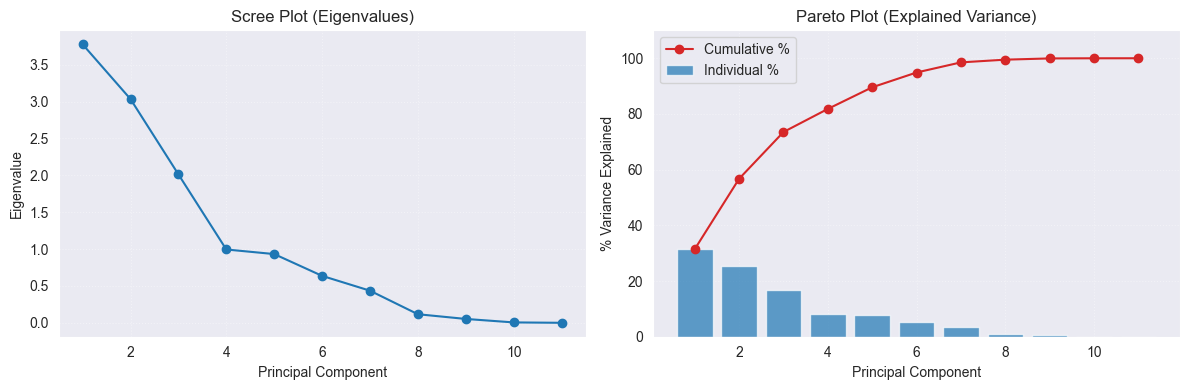

In [80]:
# Scree and Pareto plots (explained variance from PCA)
if 'eigvals' not in globals():
    raise RuntimeError('eigvals not found. Run the PCA cell first.')

pcs = np.arange(1, len(eigvals) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot (eigenvalues)
axes[0].plot(pcs, eigvals, 'o-', color='#1f77b4')
axes[0].set_title('Scree Plot (Eigenvalues)')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Eigenvalue')
axes[0].grid(True, linestyle=':', alpha=0.4)

# Pareto plot (explained and cumulative variance)
axes[1].bar(pcs, expl_var * 100.0, color='#1f77b4', alpha=0.7, label='Individual %')
axes[1].plot(pcs, cum_var * 100.0, 'o-', color='#d62728', label='Cumulative %')
axes[1].set_title('Pareto Plot (Explained Variance)')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('% Variance Explained')
axes[1].set_ylim(0, 110)
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

[24-11-2025 20:20:52] [pca.pca] [INFO] Extracting column labels from dataframe.


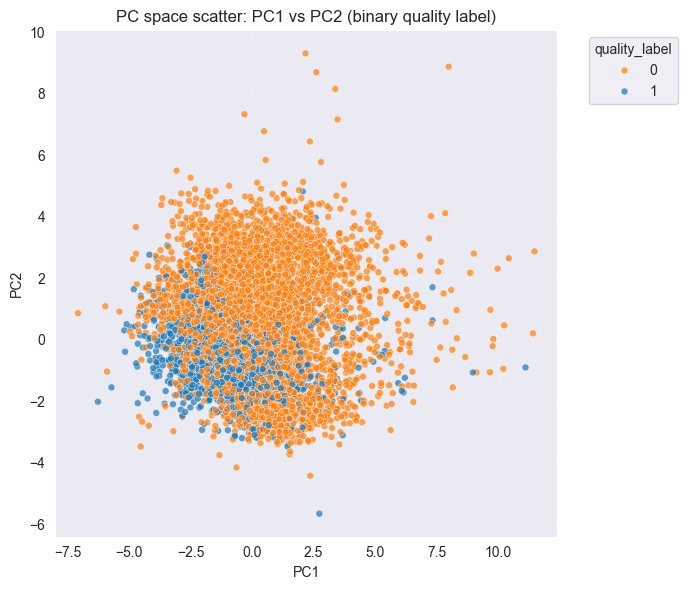

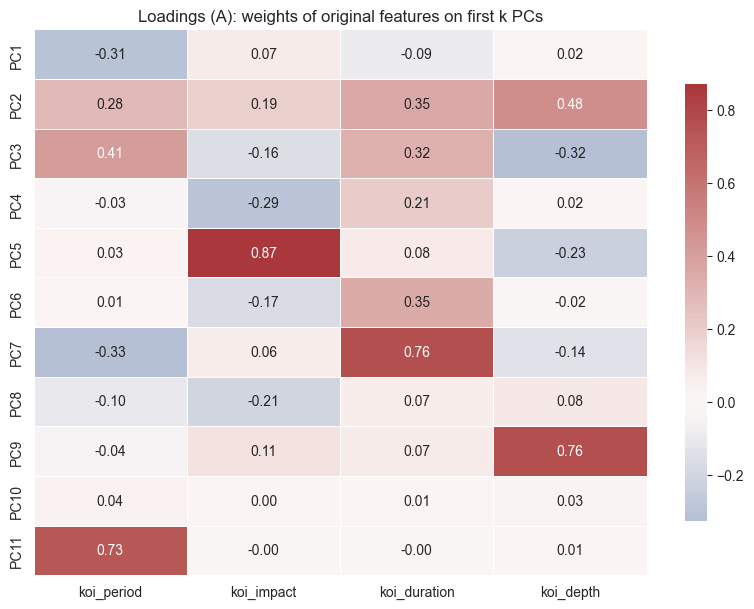

In [81]:
# PCA visualization: PC1–PC2 scatter and loadings heatmap
# Build PCA coordinates for all labeled samples for visualization
X_std_all = pd.concat([X_train_std_df, X_test_std_df], axis=0).loc[X.index]
PC_all_df = pca_model.transform(X_std_all)
# Keep only PC columns and first two components for plotting
pc_cols_all = [c for c in PC_all_df.columns if isinstance(c, str) and c.startswith('PC')]
PC_all_df = PC_all_df[pc_cols_all].iloc[:, :max(2, k)].copy()
# Align labels by the order of X_std_all (not by transformed index labels)
y_all = y.loc[X_std_all.index].astype(int).to_numpy()
PC_all_df['quality_label'] = y_all

# 1) PC1 vs PC2 scatter colored by binary label
plt.figure(figsize=(7, 6))
ax = sns.scatterplot(
    data=PC_all_df,
    x='PC1',
    y='PC2',
    hue='quality_label',
    palette={0: '#ff7f0e', 1: '#1f77b4'},
    alpha=0.7,
    s=25,
)
ax.legend(title='quality_label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('PC space scatter: PC1 vs PC2 (binary quality label)')
ax.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

# 2) Loadings heatmap for first k PCs
loadings_k = loadings.iloc[:, :k].copy()
plt.figure(figsize=(8.2, 6.2))
ax = sns.heatmap(
    loadings_k,
    cmap='vlag',
    center=0,
    annot=True,
    fmt='.2f',
    linewidths=0.4,
    cbar_kws=dict(shrink=0.8),
)
ax.set_title('Loadings (A): weights of original features on first k PCs')
plt.tight_layout()
plt.show()

# Print top-contributing features for PC1..PC3
for pc in [f'PC{i}' for i in range(1, min(3, k) + 1)]:
    if pc in loadings_k.columns:
        s = loadings_k[pc]
        top = s.abs().sort_values(ascending=False).head(5).index.tolist()
        print(f'Top contributors to {pc} (by |loading|): {", ".join(top)}')

In [82]:
# Feature matrices for ML: original standardized 12-D space and PCA-k space
# Create DataFrames for downstream ML usage (PyCaret)
x_train_original = X_train_std_df.copy()
x_test_original = X_test_std_df.copy()
x_train_pca = X_train_pca.copy()
x_test_pca = X_test_pca.copy()

# Also provide labeled DataFrames convenient for PyCaret setup()
train_original_with_y = x_train_original.copy()
train_original_with_y['quality_label'] = y_train.values

test_original_with_y = x_test_original.copy()
test_original_with_y['quality_label'] = y_test.values

train_pca_with_y = x_train_pca.copy()
train_pca_with_y['quality_label'] = y_train.values

test_pca_with_y = x_test_pca.copy()
test_pca_with_y['quality_label'] = y_test.values

print(f'Prepared matrices -> x_train_original: {x_train_original.shape}, x_test_original: {x_test_original.shape}')
print(f'Prepared matrices -> x_train_pca: {x_train_pca.shape}, x_test_pca: {x_test_pca.shape}')


Prepared matrices -> x_train_original: (5768, 12), x_test_original: (1443, 12)
Prepared matrices -> x_train_pca: (5768, 4), x_test_pca: (1443, 4)
